In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import yule_walker
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.signal import butter, filtfilt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px

In [3]:
data = pd.read_csv("Nashville Accidents Jan 2018 - Apl 2025.csv")

In [4]:
data.head()

,Accident Number,Date and Time,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Collision Type Description,Weather Description,Illumination Description,...,HarmfulDescriptions,ObjectId,Zip Code,RPA,Weather,IlluACCIDEmination,Collision Type,Reporting Officer,x,y
0,2008473471,7/14/2018 11:00:00 PM,2.0,2.0,0.0,NaN,N,ANGLE,NO ADVERSE CONDITIONS,NaN,...,NaN,1,37208.0,4525.0,1.0,1.0,4.0,225845.0,-9.664843e+06,4.323742e+06
1,2008787228,11/16/2018 9:33:00 AM,1.0,1.0,0.0,NaN,N,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,NO ADVERSE CONDITIONS,NaN,...,NaN,2,37203.0,5401.0,1.0,3.0,0.0,475881.0,-9.662645e+06,4.322558e+06
2,2009131786,2/19/2019 10:42:00 PM,1.0,1.0,0.0,NaN,N,HEAD-ON,NO ADVERSE CONDITIONS,NaN,...,NaN,3,37218.0,3235.0,1.0,1.0,2.0,562528.0,-9.674832e+06,4.329570e+06
3,2009418107,5/27/2019 9:00:00 PM,2.0,0.0,0.0,NaN,Y,REAR END,NO ADVERSE CONDITIONS,NaN,...,NaN,4,NaN,4311.0,1.0,1.0,1.0,571315.0,-9.659749e+06,4.323487e+06
4,20120135824,3/8/2021 6:05:00 PM,2.0,1.0,0.0,NaN,N,Front to Rear,CLEAR,DAYLIGHT,...,MOTOR VEHICLE IN TRANSPORT,5,37207.0,1863.0,21.0,1.0,11.0,473670.0,-9.659079e+06,4.328993e+06


In [5]:
ts = data['Number of Injuries']

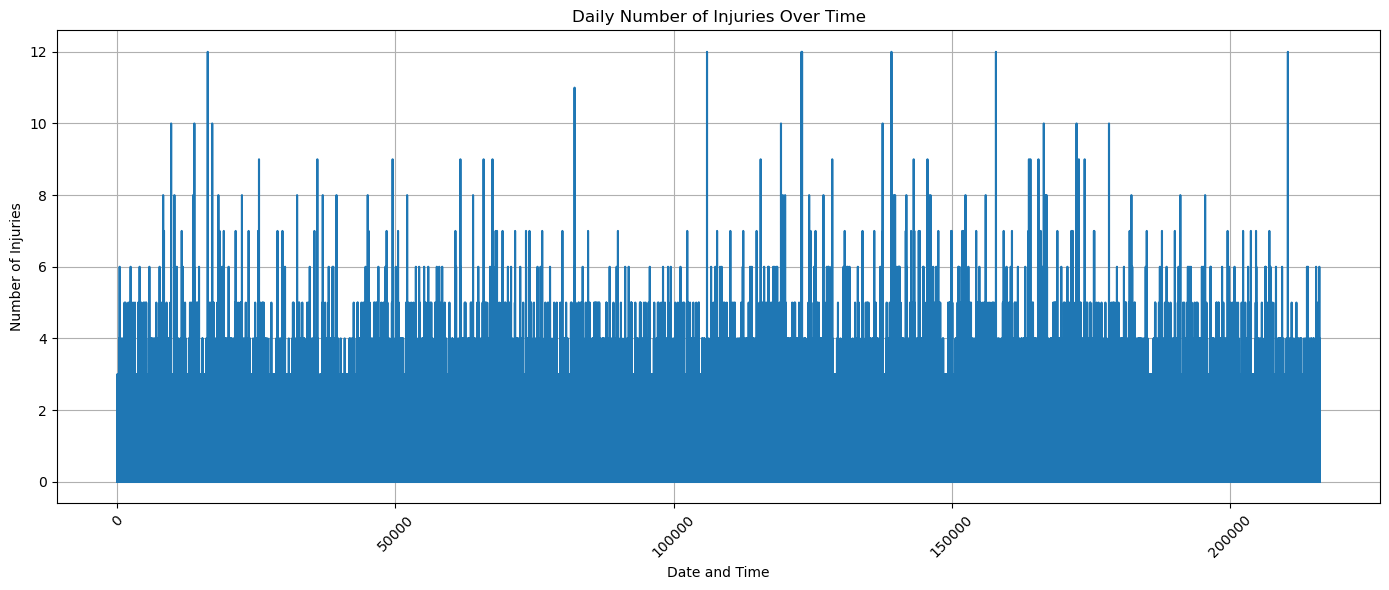

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts.values)
plt.title("Daily Number of Injuries Over Time")
plt.xlabel("Date and Time")
plt.ylabel("Number of Injuries")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: >

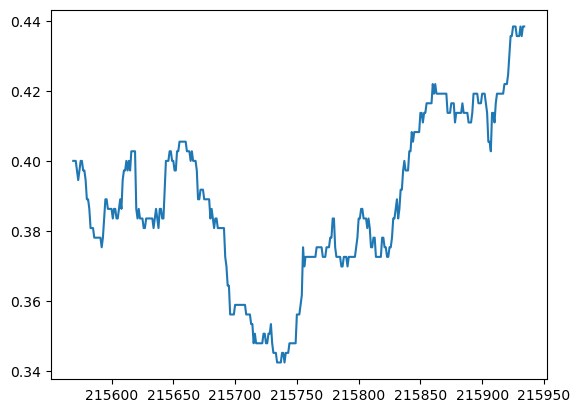

In [7]:
ts_series = pd.Series(ts).replace([np.inf, -np.inf], np.nan).dropna()
ts_subset = ts_series[-730:]
result = seasonal_decompose(ts_subset, period=365)
result.trend.plot()

<Axes: >

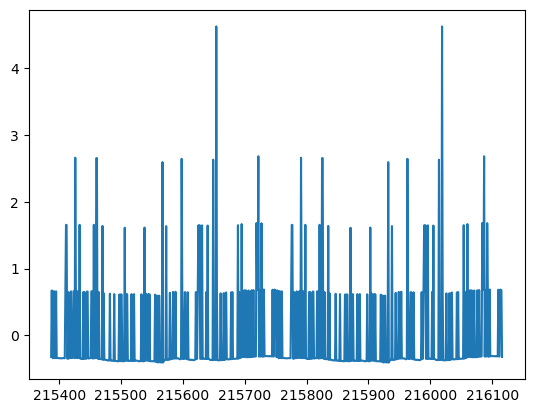

In [9]:
result.seasonal.plot()

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
import pandas as pd
import warnings

# Clean time series
ts_series = pd.Series(ts).replace([np.inf, -np.inf], np.nan).dropna()
ts_subset = ts_series[-500:]  # Use a smaller window for faster results

# Run ADF Test
adf_result = adfuller(ts_subset)
print(f"ADF p-value: {adf_result[1]:.10f}")

# Suppress KPSS InterpolationWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    kpss_result = kpss(ts_subset, regression='c', nlags='auto')

print(f"KPSS p-value: {kpss_result[1]:.10f}")



ADF p-value: 0.0000000000
KPSS p-value: 0.1000000000


In [13]:
if kpss_result[1] > 0.05:
    print("Data is Stationary")
else:
    print("Data is non Stationary")

Data is Stationary


In [14]:
if adf_result[1] > 0.5:
    print('Non Stationary')
    d = 1
    diff = data['Birth'].diff().dropna()
    result_diff = adfuller(diff)
    if result_diff[1] > 0.5:
        print('Non Stationary')
        d = 2
    print('Value of d = ' , d)
else:
    d=0
    print('data is stationary: ',d)

data is stationary:  0


In [16]:
#Rolling Mean and Stadard deviation from Number of Inguries
rolling_mean = ts.rolling(window=12).mean()
rolling_std = ts.rolling(window=12).std()

<Axes: >

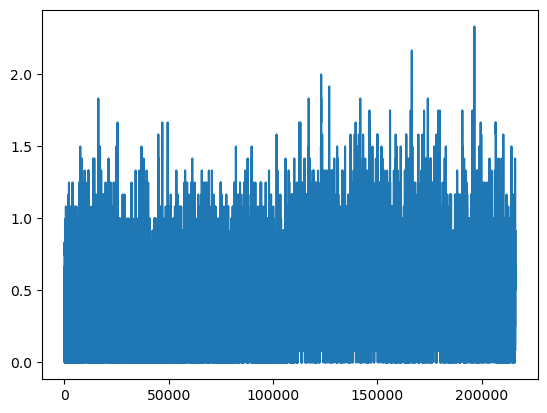

In [17]:
rolling_mean.plot()

<Axes: >

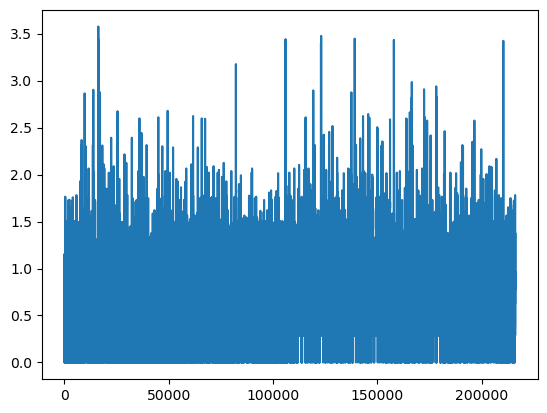

In [19]:
rolling_std.plot()

In [21]:
split = int(len(ts_subset) * 0.7)  # 70% for training
train = ts_subset[:split]
test = ts_subset[split:]

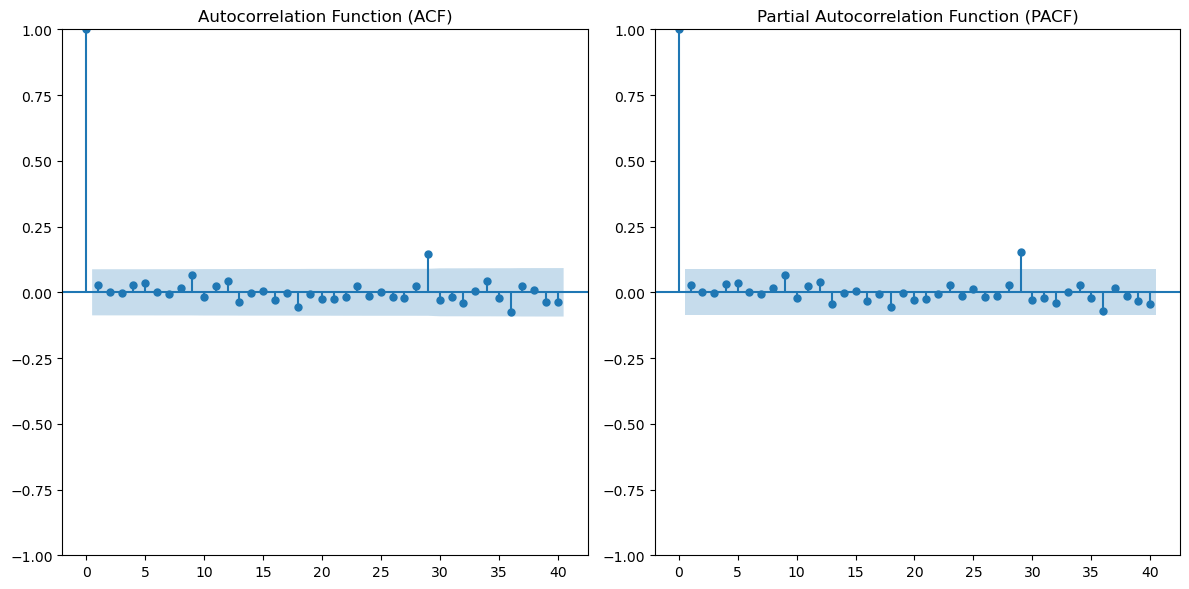

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(121)
plot_acf(ts_subset, lags=40, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelation Function (ACF)')

# PACF Plot
plt.subplot(122)
plot_pacf(ts_subset, lags=40, ax=plt.gca(), alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [27]:
from pmdarima import auto_arima

In [28]:
model = auto_arima(ts_subset)

In [29]:
print('p d q = ' , model.order) 

p d q =  (0, 0, 0)


In [31]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                        SARIMAX   Log Likelihood                -595.075
Date:                Mon, 05 May 2025   AIC                           1194.151
Time:                        13:38:48   BIC                           1202.580
Sample:                             0   HQIC                          1197.458
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4280      0.055      7.745      0.000       0.320       0.536
sigma2         0.6328      0.026     24.756      0.000       0.583       0.683
Ljung-Box (L1) (Q):                   0.34   Jarque-

<Axes: >

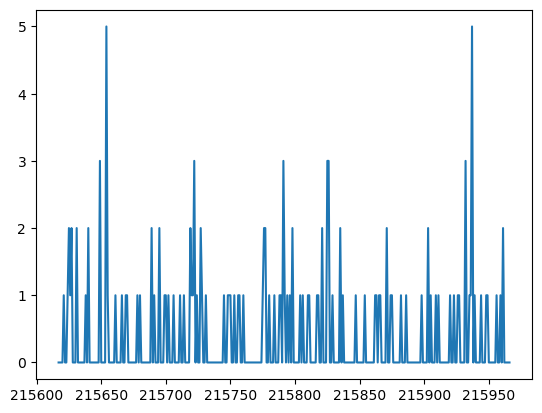

In [32]:
train.plot()

In [33]:
#BANDPASS FILTER
nyq = 0.5
low = 0.01 / nyq  
high = 0.1 / nyq   

b, a = butter(N=2, Wn=[low, high], btype='bandpass')

ts_bandpass = filtfilt(b, a, ts_subset.values)  


ts_bandpass = pd.Series(ts_bandpass, index=ts_subset.index)

In [36]:
ts_bandpass

215617   -0.072595
215618   -0.048643
215619   -0.002169
215620    0.080905
215621    0.203500
            ...   
216112    0.342064
216113    0.493562
216114    0.505657
216115    0.345659
216116    0.065263
Length: 500, dtype: float64

<Axes: >

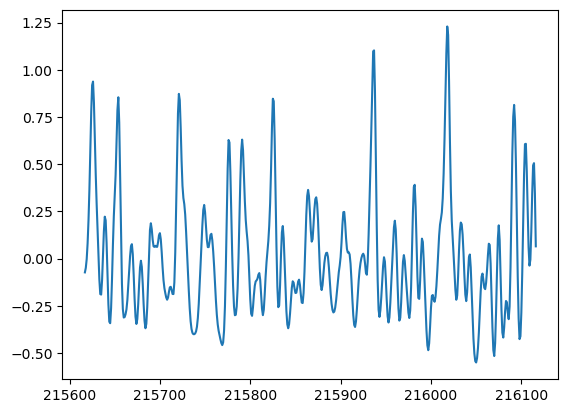

In [37]:
ts_bandpass.plot()

In [38]:
#smoothing
ts_rolling = ts.rolling(window=3).mean()
ts_exp = ts.ewm(span=3).mean()
ts_centered = ts.rolling(window=3, center=True).mean()

In [39]:
ts_centered

0              NaN
1         1.333333
2         0.666667
3         0.666667
4         0.333333
            ...   
216112    0.666667
216113    0.666667
216114    1.333333
216115    0.666667
216116         NaN
Name: Number of Injuries, Length: 216117, dtype: float64

<Axes: >

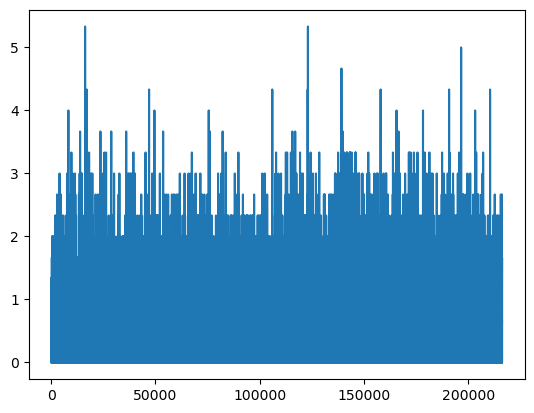

In [41]:
ts_centered.plot()

In [42]:
from scipy.stats import pearsonr
model = ARIMA(train, order=model.order)
model_fit = model.fit()

# Make forecasts
forecast = model_fit.forecast(steps=len(test))

# Calculate errors
errors = test - forecast
abs_errors = np.abs(errors)
percentage_errors = (errors / test) * 100
abs_percentage_errors = np.abs(percentage_errors)

# Calculate all metrics
ME = np.mean(errors)  # Mean Error
MAE = mean_absolute_error(test, forecast)  # Mean Absolute Error
MPE = np.mean(percentage_errors)  # Mean Percentage Error
MAPE = np.mean(abs_percentage_errors)  # Mean Absolute Percentage Error
RMSE = np.sqrt(mean_squared_error(test, forecast))  # Root Mean Squared Error
ACF1 = acf(errors, nlags=1, fft=False)[1]  # Lag 1 Autocorrelation of Error
corr = pearsonr(test, forecast)[0]  # Correlation between Actual and Forecast
minmax = 1 - (np.max(abs_errors) / (np.max(test) - np.min(test)))  # Min-Max Error

# Print all metrics
print("ARIMA Model Evaluation Metrics:")
print(f"Mean Error (ME): {ME:.4f}")
print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Percentage Error (MPE): {MPE:.4f}%")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.4f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"Lag 1 Autocorrelation of Error (ACF1): {ACF1:.4f}")
print(f"Correlation between Actual and Forecast (corr): {corr:.4f}")
print(f"Min-Max Error (minmax): {minmax:.4f}")

# Optional: Create a DataFrame to display metrics neatly
metrics_df = pd.DataFrame({
    'Metric': ['Mean Error (ME)', 'Mean Absolute Error (MAE)', 
               'Mean Percentage Error (MPE)', 'Mean Absolute Percentage Error (MAPE)',
               'Root Mean Squared Error (RMSE)', 'Lag 1 Autocorrelation of Error (ACF1)',
               'Correlation (corr)', 'Min-Max Error (minmax)'],
    'Value': [ME, MAE, MPE, MAPE, RMSE, ACF1, corr, minmax]
})
print("\nMetrics Table:")
print(metrics_df)

ARIMA Model Evaluation Metrics:
Mean Error (ME): nan
Mean Absolute Error (MAE): 0.6515
Mean Percentage Error (MPE): nan%
Mean Absolute Percentage Error (MAPE): nan%
Root Mean Squared Error (RMSE): 0.9205
Lag 1 Autocorrelation of Error (ACF1): nan
Correlation between Actual and Forecast (corr): nan
Min-Max Error (minmax): nan

Metrics Table:
                                  Metric     Value
0                        Mean Error (ME)       NaN
1              Mean Absolute Error (MAE)  0.651465
2            Mean Percentage Error (MPE)       NaN
3  Mean Absolute Percentage Error (MAPE)       NaN
4         Root Mean Squared Error (RMSE)  0.920508
5  Lag 1 Autocorrelation of Error (ACF1)       NaN
6                     Correlation (corr)       NaN
7                 Min-Max Error (minmax)       NaN


C:\Users\asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, ca